In [1]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

In [2]:
from SiPANN import scee
from SiPANN.scee_int import SimphonyWrapper
from simphony.library import siepic
from simphony.netlist import Subcircuit
from simphony.simulation import SweepSimulation
from simphony.tools import freq2wl

In [3]:
# Have a main data line where frequency multiplexed data enters the circuit.
wg_data = siepic.ebeam_wg_integral_1550(100e-6)

# A terminator for dispersing unused light
term = siepic.ebeam_terminator_te1550()

In [4]:
def ring_factory(radius):
    """
    Creates a full ring (with terminator) from a half ring.

    Ports of a half ring are ordered like so:
    2           4
    |         |
     \       /
      \     /
    ---=====---
    1           3

    Resulting pins are ('in', 'out', 'pass').

    Parameters
    ----------
    radius : float
        The radius of the ring resonator, in nanometers.
    """
    # Have rings for selecting out frequencies from the data line.
    # See SiPANN's model API for argument order and units.
    half_ring = SimphonyWrapper(scee.HalfRing(500, 220, radius, 100))

    circuit = Subcircuit()
    circuit.add([
        (half_ring, 'input'),
        (half_ring, 'output'),
        (term, 'terminator')
    ])

    circuit.elements['input'].pins = ('pass', 'midb', 'in', 'midt')
    circuit.elements['output'].pins = ('out', 'midt', 'term', 'midb')

    circuit.connect_many([
        ('input', 'midb', 'output', 'midb'),
        ('input', 'midt', 'output', 'midt'),
        ('terminator', 'n1', 'output', 'term')
    ])

    return circuit

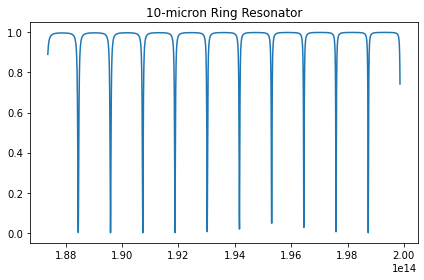

In [5]:
# Behold, we can run a simulation on a single ring resonator.
cir1 = ring_factory(10000)
sim1 = SweepSimulation(cir1, 1500e-9, 1600e-9)
res1 = sim1.simulate()

f1, s = res1.data(res1.pinlist['in'], res1.pinlist['pass'])
plt.plot(f1, s)
plt.title("10-micron Ring Resonator")
plt.tight_layout()
plt.show()

In [6]:
# Now, we'll create the circuit (using several ring resonator subcircuits)
# and add all individual instances.
circuit = Subcircuit('Add-Drop Filter')
e = circuit.add([
    (wg_data, 'input'),
    (ring_factory(10000), 'ring10'),
    (wg_data, 'out1'),

    (wg_data, 'connect1'),
    (ring_factory(11000), 'ring11'),
    (wg_data, 'out2'),

    (wg_data, 'connect2'),
    (ring_factory(12000), 'ring12'),
    (wg_data, 'out3'),

    (term, 'terminator')
])

In [7]:
# You can set pin names individually (here I'm naming all the outputs that
# I'll want to access after the simulation has been run):
circuit.elements['input'].pins['n1'] = 'input'
circuit.elements['out1'].pins['n2'] = 'out1'
circuit.elements['out2'].pins['n2'] = 'out2'
circuit.elements['out3'].pins['n2'] = 'out3'


In [8]:
circuit.connect_many([
    ('input', 'n2', 'ring10', 'in'),
    ('out1', 'n1', 'ring10', 'out'),
    ('connect1', 'n1', 'ring10', 'pass'),

    ('connect1', 'n2', 'ring11', 'in'),
    ('out2', 'n1', 'ring11', 'out'),
    ('connect2', 'n1', 'ring11', 'pass'),

    ('connect2', 'n2', 'ring12', 'in'),
    ('out3', 'n1', 'ring12', 'out'),
    ('terminator', 'n1', 'ring12', 'pass'),
])

In [9]:
# Run a simulation on the netlist.
simulation = SweepSimulation(circuit, 1524.5e-9, 1551.15e-9)
result = simulation.simulate()

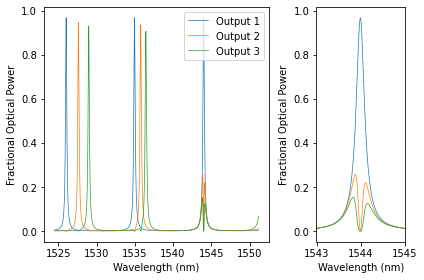

In [10]:
fig = plt.figure(tight_layout=True)
gs = gridspec.GridSpec(1, 3)

ax = fig.add_subplot(gs[0, :2])
f, s = result.data('input', 'out1')
ax.plot(freq2wl(f)*1e9, s, label='Output 1', lw='0.7')
f, s = result.data('input', 'out2')
ax.plot(freq2wl(f)*1e9, s, label='Output 2', lw='0.7')
f, s = result.data('input', 'out3')
ax.plot(freq2wl(f)*1e9, s, label='Output 3', lw='0.7')

ax.set_ylabel("Fractional Optical Power")
ax.set_xlabel("Wavelength (nm)")
plt.legend(loc='upper right')

ax = fig.add_subplot(gs[0, 2])
f, s = result.data('input', 'out1')
ax.plot(freq2wl(f)*1e9, s, label='Output 1', lw='0.7')
f, s = result.data('input', 'out2')
ax.plot(freq2wl(f)*1e9, s, label='Output 2', lw='0.7')
f, s = result.data('input', 'out3')
ax.plot(freq2wl(f)*1e9, s, label='Output 3', lw='0.7')

ax.set_xlim(1543,1545)
ax.set_ylabel("Fractional Optical Power")
ax.set_xlabel("Wavelength (nm)")

fig.align_labels()
plt.show()
